In [1]:
#!pip install pillow

## Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Load data

#### We use grayscale color mode since these are X-ray images. Binary class mode is used to distinguish between normal and pneumonia images.

In [3]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132, color_mode='grayscale', class_mode='binary')

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790, color_mode='grayscale', class_mode='binary')

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [4]:
print(train_labels[:10])

[0. 1. 0. 1. 1. 0. 1. 1. 1. 1.]


## PREPROCESSING
#### Create validation set from training set

In [5]:
X = train_images
y = train_labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [6]:
train_images.shape

(790, 64, 64, 1)

#### Preview images (Normal)

In [7]:
print('X_train shape: ',np.shape(X_train))
print('y_train shape: ',np.shape(y_train))
print('X_val shape: ',np.shape(X_val))
print('y_val shape: ',np.shape(y_val))

X_train shape:  (632, 64, 64, 1)
y_train shape:  (632,)
X_val shape:  (158, 64, 64, 1)
y_val shape:  (158,)


In [8]:
test_images.shape

(132, 64, 64, 1)

#### Reshape  images

In [9]:
#train set
X_train_unrow = X_train.reshape(632, -1)
X_train_unrow.shape

(632, 4096)

In [10]:
#test set
X_val_unrow = X_val.reshape(158, -1)
X_val_unrow.shape

(158, 4096)

#### Labels for images

In [11]:
y_train[:10]

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [12]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Reshape Labels 

In [13]:
# #training set
# y_train_labels_final = np.reshape(y_train[:,0], (632,1))

In [14]:
# np.shape(y_train_labels_final)

In [15]:
#test set
# y_val_labels_final = np.reshape(y_val[:,0], (158,1))

In [16]:
# np.shape(y_val_labels_final) 

In [17]:
#scaling the data
X_train_img_final = X_train_unrow/255
X_val_img_final = X_val_unrow/255

type(X_val_img_final)

numpy.ndarray

In [18]:
print(X_train_img_final.shape)
print(X_val_img_final.shape)

(632, 4096)
(158, 4096)


## Model creation
#### We will use recall as our metric, as we're more concerned about false negatives than false positives.

#### Baseline Model with DummyClassifier

In [19]:
#dummy classifer/regressor for baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_img_final, y_train)

DummyClassifier(strategy='most_frequent')

In [20]:
dummy.predict(X_val_img_final)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)

In [21]:
dummy.score(X_val_img_final, y_val)

0.7468354430379747

#### Initial Neural Network Model Creation using tanh activation function

In [22]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(63, activation='softmax', input_shape=(4096,)))
model.add(layers.Dense(42, activation='softmax'))
model.add(layers.Dense(21, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [23]:
# import tensorflow as tf

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results = model.fit(X_train_img_final,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val))

Epoch 1/50
20/20 [==============================] - 0s 20ms/step - loss: 0.6671 - recall: 1.0000 - val_loss: 0.6628 - val_recall: 1.0000
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6562 - recall: 1.0000 - val_loss: 0.6531 - val_recall: 1.0000
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.6464 - recall: 1.0000 - val_loss: 0.6443 - val_recall: 1.0000
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6376 - recall: 1.0000 - val_loss: 0.6365 - val_recall: 1.0000
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6296 - recall: 1.0000 - val_loss: 0.6295 - val_recall: 1.0000
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6224 - recall: 1.0000 - val_loss: 0.6232 - val_recall: 1.0000
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6160 - recall: 1.0000 - val_loss: 0.6176 - val_recall: 1.0000
Epoch 8/50
20/20 [=============================

In [24]:
results_train = model.evaluate(X_train_img_final, y_train)

20/20 [==============================] - 0s 1ms/step - loss: 0.5532 - recall: 1.0000


In [25]:
results_val = model.evaluate(X_val_img_final, y_val)

5/5 [==============================] - 0s 1ms/step - loss: 0.5661 - recall: 1.0000


In [26]:
#plot epochs vs loss for train and test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    

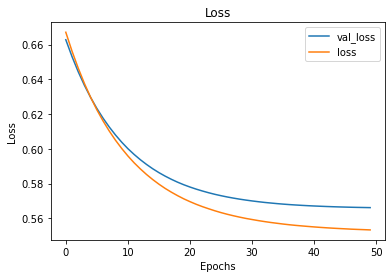

In [27]:
visualize_results(results)

#### Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve. Any subsequent models must reduce the variance and overfitting of the baseline model.


In [28]:
# For Tuesday: Resolve overfitting(EarlyStopping), Attempt L1, L2 or dropout regularization, determine if normalization is 
# necessary, create convolution filter. After that, look at weight initializers (Lecun and He), optmizers(RMSProp, Adam)

#### Will adding EarlyStopping improve the model?

In [29]:
#create new model with similar parameters
np.random.seed(42)
model2 = models.Sequential()
model2.add(layers.Dense(63, activation='softmax', input_shape=(4096,)))
model2.add(layers.Dense(42, activation='softmax'))
model2.add(layers.Dense(21, activation='softmax'))
model2.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [30]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model.h5',
                                                                                 monitor='val_loss', save_best_only=True)]

In [31]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results2 = model2.fit(X_train_img_final,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_img_final, y_val))

Epoch 1/50
20/20 [==============================] - 0s 16ms/step - loss: 0.6559 - recall_1: 1.0000 - val_loss: 0.6528 - val_recall_1: 1.0000
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.6462 - recall_1: 1.0000 - val_loss: 0.6441 - val_recall_1: 1.0000
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6373 - recall_1: 1.0000 - val_loss: 0.6364 - val_recall_1: 1.0000
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.6295 - recall_1: 1.0000 - val_loss: 0.6294 - val_recall_1: 1.0000
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6224 - recall_1: 1.0000 - val_loss: 0.6232 - val_recall_1: 1.0000
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.6160 - recall_1: 1.0000 - val_loss: 0.6175 - val_recall_1: 1.0000
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.6101 - recall_1: 1.0000 - val_loss: 0.6125 - val_recall_1: 1.0000
Epoch 8/50
20/20 [=

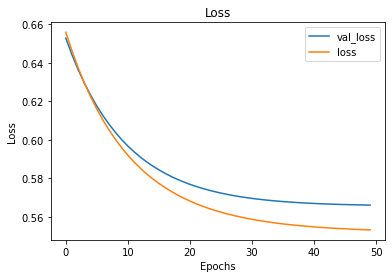

In [32]:
visualize_results(results2)

#### Variation in val_loss is still very high. Additionally, overfitting issue still hasn't been resolved. Will build a CNN, then attempt to control overfitting.

In [33]:
#CNN model
np.random.seed(42)
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1)))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='softmax'))
model3.add(layers.Dense(42, activation='softmax'))
model3.add(layers.Dense(21, activation='softmax'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_9 (Dense)              (None, 42)                2730      
_________________________________________________________________
dense_10 (Dense)             (None, 21)                903       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 22        
Total params: 7,876,551
Trainable params: 7,876,551
Non-trainable params: 0
____________________________________________

In [35]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results3 = model3.fit(X_train,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 96ms/step - loss: 0.7033 - recall_2: 0.0000e+00 - val_loss: 0.6952 - val_recall_2: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 2s 84ms/step - loss: 0.6888 - recall_2: 0.8375 - val_loss: 0.6822 - val_recall_2: 1.0000
Epoch 3/50
20/20 [==============================] - 2s 83ms/step - loss: 0.6758 - recall_2: 1.0000 - val_loss: 0.6705 - val_recall_2: 1.0000
Epoch 4/50
20/20 [==============================] - 2s 82ms/step - loss: 0.6640 - recall_2: 1.0000 - val_loss: 0.6601 - val_recall_2: 1.0000
Epoch 5/50
20/20 [==============================] - 2s 82ms/step - loss: 0.6535 - recall_2: 1.0000 - val_loss: 0.6507 - val_recall_2: 1.0000
Epoch 6/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6440 - recall_2: 1.0000 - val_loss: 0.6423 - val_recall_2: 1.0000
Epoch 7/50
20/20 [==============================] - 2s 86ms/step - loss: 0.6355 - recall_2: 1.0000 - val_loss: 0.6346 - val_recall_2: 1.0000
Epoch

In [54]:
results_train4 = model3.evaluate(X_train, y_train)

20/20 [==============================] - 0s 18ms/step - loss: 0.5535 - recall_2: 1.0000


In [55]:
results_val4 = model3.evaluate(X_val, y_val)

5/5 [==============================] - 0s 15ms/step - loss: 0.5663 - recall_2: 1.0000


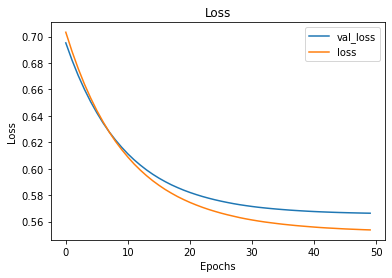

In [36]:
visualize_results(results3)

#### The variation has been reduced, but there is still overfitting. From here, we will attempt L1 and L2 regularization

#### L2 regularization with model3 structure

In [37]:
np.random.seed(42)


lambda_coeff = 0.005

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(42, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(21, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model4.add(layers.Dense(1, activation='sigmoid'))

In [38]:
model4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results4 = model4.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 119ms/step - loss: 1.7524 - recall_3: 0.0000e+00 - val_loss: 1.7415 - val_recall_3: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 2s 108ms/step - loss: 1.7332 - recall_3: 0.4333 - val_loss: 1.7238 - val_recall_3: 1.0000
Epoch 3/50
20/20 [==============================] - 2s 106ms/step - loss: 1.7155 - recall_3: 1.0000 - val_loss: 1.7075 - val_recall_3: 1.0000
Epoch 4/50
20/20 [==============================] - 2s 108ms/step - loss: 1.6991 - recall_3: 1.0000 - val_loss: 1.6925 - val_recall_3: 1.0000
Epoch 5/50
20/20 [==============================] - 2s 108ms/step - loss: 1.6840 - recall_3: 1.0000 - val_loss: 1.6785 - val_recall_3: 1.0000
Epoch 6/50
20/20 [==============================] - 2s 121ms/step - loss: 1.6699 - recall_3: 1.0000 - val_loss: 1.6655 - val_recall_3: 1.0000
Epoch 7/50
20/20 [==============================] - 3s 133ms/step - loss: 1.6569 - recall_3: 1.0000 - val_loss: 1.6536 - val_recall_3: 1.000

In [52]:
results_train4 = model4.evaluate(X_train, y_train)

20/20 [==============================] - 0s 24ms/step - loss: 1.4092 - recall_3: 1.0000


In [53]:
results_val4 = model4.evaluate(X_val, y_val)

5/5 [==============================] - 0s 20ms/step - loss: 1.4219 - recall_3: 1.0000


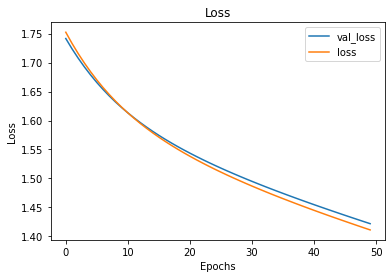

In [39]:
visualize_results(results4)

#### Insight: the curve variablity has improved! Will reduce model complexity to reduce the loss function and train the model against the entire training set

In [40]:
#reducing layers and nodes within layers
np.random.seed(42)

lambda_coeff = 0.005

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1), padding='same'))

model5.add(layers.Flatten())
model5.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model5.add(layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))

model5.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model5.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results5 = model5.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 90ms/step - loss: 0.9286 - recall_4: 0.0000e+00 - val_loss: 0.9069 - val_recall_4: 0.3305
Epoch 2/50
20/20 [==============================] - 2s 78ms/step - loss: 0.8916 - recall_4: 0.9625 - val_loss: 0.8820 - val_recall_4: 1.0000
Epoch 3/50
20/20 [==============================] - 2s 77ms/step - loss: 0.8739 - recall_4: 1.0000 - val_loss: 0.8688 - val_recall_4: 1.0000
Epoch 4/50
20/20 [==============================] - 2s 78ms/step - loss: 0.8610 - recall_4: 1.0000 - val_loss: 0.8574 - val_recall_4: 1.0000
Epoch 5/50
20/20 [==============================] - 2s 79ms/step - loss: 0.8497 - recall_4: 1.0000 - val_loss: 0.8474 - val_recall_4: 1.0000
Epoch 6/50
20/20 [==============================] - 2s 77ms/step - loss: 0.8396 - recall_4: 1.0000 - val_loss: 0.8385 - val_recall_4: 1.0000
Epoch 7/50
20/20 [==============================] - 2s 77ms/step - loss: 0.8306 - recall_4: 1.0000 - val_loss: 0.8306 - val_recall_4: 1.0000
Epoch 8/5

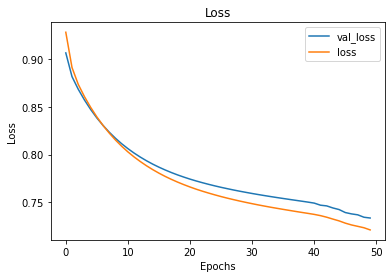

In [42]:
visualize_results(results5)

In [43]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2097168   
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 2,097,633
Trainable params: 2,097,633
Non-trainable params: 0
_________________________________________________________________


#### Dropout regularization tests to reduce complexity

In [44]:
np.random.seed(42)

model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1)))

model6.add(layers.Flatten())
model6.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(lambda_coeff)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model6.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results6 = model6.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 85ms/step - loss: 0.9159 - recall_5: 0.4583 - val_loss: 0.9026 - val_recall_5: 1.0000
Epoch 2/50
20/20 [==============================] - 2s 87ms/step - loss: 0.8910 - recall_5: 0.7750 - val_loss: 0.8846 - val_recall_5: 1.0000
Epoch 3/50
20/20 [==============================] - 2s 108ms/step - loss: 0.8772 - recall_5: 0.9271 - val_loss: 0.8709 - val_recall_5: 1.0000
Epoch 4/50
20/20 [==============================] - 2s 94ms/step - loss: 0.8645 - recall_5: 0.9750 - val_loss: 0.8599 - val_recall_5: 1.0000
Epoch 5/50
20/20 [==============================] - 2s 86ms/step - loss: 0.8560 - recall_5: 0.9812 - val_loss: 0.8504 - val_recall_5: 1.0000
Epoch 6/50
20/20 [==============================] - 2s 89ms/step - loss: 0.8457 - recall_5: 0.9979 - val_loss: 0.8420 - val_recall_5: 1.0000
Epoch 7/50
20/20 [==============================] - 2s 108ms/step - loss: 0.8362 - recall_5: 1.0000 - val_loss: 0.8344 - val_recall_5: 1.0000
Epoch 8/50


In [46]:
results_train6 = model6.evaluate(X_train, y_train)

20/20 [==============================] - 0s 16ms/step - loss: 0.7305 - recall_5: 1.0000


In [47]:
results_val6 = model6.evaluate(X_val, y_val)

5/5 [==============================] - 0s 14ms/step - loss: 0.7436 - recall_5: 1.0000


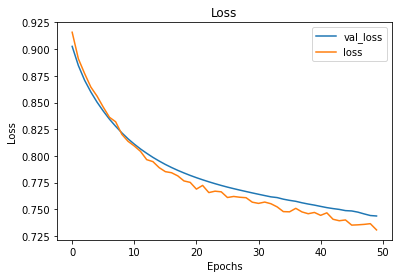

In [48]:
visualize_results(results6)

#### dropout drastically reduces variance. Will also attempt BatchNormalization

In [49]:
#introducing padding
np.random.seed(42)
model7 = models.Sequential()
model7.add(layers.Conv2D(32, (3,3), activation='softmax',
                        input_shape=(64, 64, 1), padding='same'))

model7.add(layers.Flatten())
model7.add(layers.Dense(42, activation='softmax'))
model7.add(layers.Dropout(0.3))
model7.add(layers.Dense(21, activation='softmax'))
model7.add(layers.Dropout(0.3))
model7.add(layers.Dense(1, activation='sigmoid'))

In [50]:
model7.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

results7 = model7.fit(X_train, 
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
20/20 [==============================] - 2s 93ms/step - loss: 0.7046 - recall_6: 0.2292 - val_loss: 0.6951 - val_recall_6: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 2s 101ms/step - loss: 0.6882 - recall_6: 0.6583 - val_loss: 0.6819 - val_recall_6: 1.0000
Epoch 3/50
20/20 [==============================] - 2s 104ms/step - loss: 0.6765 - recall_6: 0.9458 - val_loss: 0.6702 - val_recall_6: 1.0000
Epoch 4/50
20/20 [==============================] - 2s 95ms/step - loss: 0.6657 - recall_6: 0.9958 - val_loss: 0.6596 - val_recall_6: 1.0000
Epoch 5/50
20/20 [==============================] - 2s 91ms/step - loss: 0.6537 - recall_6: 1.0000 - val_loss: 0.6502 - val_recall_6: 1.0000
Epoch 6/50
20/20 [==============================] - 2s 96ms/step - loss: 0.6424 - recall_6: 1.0000 - val_loss: 0.6417 - val_recall_6: 1.0000
Epoch 7/50
20/20 [==============================] - 2s 84ms/step - loss: 0.6341 - recall_6: 1.0000 - val_loss: 0.6341 - val_recall_6: 1.0000
Epoch 8

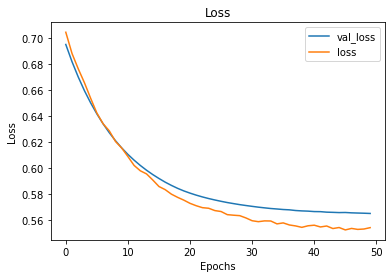

In [51]:
visualize_results(results7)

## Insight: After attempting regularization and dropout, model 3 consistently outperforms subsequent models due to have the lowest variance and loss for both train and validation sets. We will retrain the model against the entire training set and validate against the test set.